# Mario Christofell L.Tobing

Project 3 Dicoding Modul Belajar Pengembangan Machine Learning

*   Image Classification Model Deployment
*   Dataset from Kaggle : Shoe vs Sandal vs Boot Image Dataset (15K Images) (https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images)



# Import Library

In [60]:
import os
import shutil
import zipfile
import matplotlib.pyplot as plt
import splitfolders
import pathlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# Install & Upload Dataset Kaggle

In [2]:
# install kaggle package
!pip install -q kaggle

In [3]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mariochris","key":"cfcbf556ad8e73e0c0071a1e273d5fe2"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [13]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images -p /content/img/ --unzip

 68% 32.0M/47.0M [00:00<00:00, 182MB/s] 
100% 47.0M/47.0M [00:00<00:00, 186MB/s]


# Split Folder

In [22]:
local_dir = '/img/Shoe vs Sandal vs Boot Dataset/' # direktori pertama
if ('datast' in os.listdir(local_dir)):
  shutil.rmtree(os.path.join(local_dir, 'datast'))

splitfolders.ratio('/img/Shoe vs Sandal vs Boot Dataset/', output ='/img/Shoe vs Sandal vs Boot Dataset/datast',
                    seed=None, ratio=(.8,.2)) # pembagian untuk ukuran data training sebesar 80% dan validation 20%

# Direktori masing -masing jenis gambar rock, paper, scissors
boot = os.path.join('/img/Shoe vs Sandal vs Boot Dataset/Boot') # direktori jenis gambar Boct
sandal = os.path.join('/img/Shoe vs Sandal vs Boot Dataset/Sandal') # direktori jenis gambar Sandal
sshoe = os.path.join('/img/Shoe vs Sandal vs Boot Dataset/Shoe') # direktori jenis gambar Shoe

# Direktori pada Data Training dari tiap jenis gambar (80%)
boot_train = os.path.join('/img/Shoe vs Sandal vs Boot Dataset/datast/train/Boot') # banyaknya jenis gambar rock pada data training
sandal_train = os.path.join('/img/Shoe vs Sandal vs Boot Dataset/datast/train/Sandal') # banyaknya jenis gambar paper pada data training
shoe_train = os.path.join('/img/Shoe vs Sandal vs Boot Dataset/datast/train/Shoe') # banyaknya jenis gambar scissors pada data training

# Direktori pada Data Validation dari tiap jenis gambar (20%)
boot_val = os.path.join('/img/Shoe vs Sandal vs Boot Dataset/datast/val/Boot') # banyaknya jenis gambar rock pada data validation
sandal_val = os.path.join('/img/Shoe vs Sandal vs Boot Dataset/datast/val/Sandal') # banyaknya jenis gambar paper pada data validation 
shoe_val = os.path.join('/img/Shoe vs Sandal vs Boot Dataset/datast/val/Shoe') # banyaknya jenis gambar scissors pada data validation

Copying files: 15000 files [00:02, 6367.47 files/s]


# Augmentasi with ImgaeDataGenerator

In [24]:
train_dir = "/img/Shoe vs Sandal vs Boot Dataset/datast/train"
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

val_dir = "/img/Shoe vs Sandal vs Boot Dataset/datast/val"
val_datagen = ImageDataGenerator(
                    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
	train_dir, # direktori data training
	target_size=(150,150), # ukuran reolusi gambar diubah menjadi 150x150 pixel
  batch_size=10,
	class_mode='categorical' # klasifikasi yang akan dilakukan adalah multi kelas maka menggunakan categorical
)

validation_generator = val_datagen.flow_from_directory(
	val_dir, # direktori data validasi
	target_size=(150,150), # ukuran reolusi gambar diubah menjadi 150x150 pixel
  batch_size=10,
	class_mode='categorical' # klasifikasi yang akan dilakukan adalah multi kelas maka menggunakan categorcial
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


# Model

In [39]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)), # konvulusi 1
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), # konvulusi 2
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), # konvulusi 3
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), # konvulusi 4
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') # menggunakan fungsi aktivasi 'softmax' karena klasifikasi yang dilakukan merupakan multi kelas 
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

# Callback Function

In [51]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nThe accuracy has reached > 90%!")
      self.model.stop_training = True

callbacks = myCallback()

# Train Model

In [52]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=10,
      batch_size=128,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=5,
      verbose=1,
      callbacks=[callbacks])

Epoch 1/30
10/10 [==============================] - 6s 583ms/step - loss: 0.4474 - accuracy: 0.8600 - val_loss: 0.1662 - val_accuracy: 0.9200
Epoch 2/30
10/10 [==============================] - 8s 776ms/step - loss: 0.3355 - accuracy: 0.8600 - val_loss: 0.2543 - val_accuracy: 0.9000
Epoch 3/30
10/10 [==============================] - 6s 589ms/step - loss: 0.2522 - accuracy: 0.8900 - val_loss: 0.3141 - val_accuracy: 0.8800
Epoch 4/30
10/10 [==============================] - 6s 596ms/step - loss: 0.3461 - accuracy: 0.8600 - val_loss: 0.0998 - val_accuracy: 0.9800
Epoch 5/30
10/10 [==============================] - 6s 578ms/step - loss: 0.2624 - accuracy: 0.8700 - val_loss: 0.4158 - val_accuracy: 0.8600
Epoch 6/30
10/10 [==============================] - 6s 595ms/step - loss: 0.2986 - accuracy: 0.8700 - val_loss: 0.0984 - val_accuracy: 0.9800
Epoch 7/30
10/10 [==============================] - 6s 659ms/step - loss: 0.2851 - accuracy: 0.8700 - val_loss: 0.3491 - val_accuracy: 0.8200
Epoch 

# Visualization Plot Accuracy & Loss Model

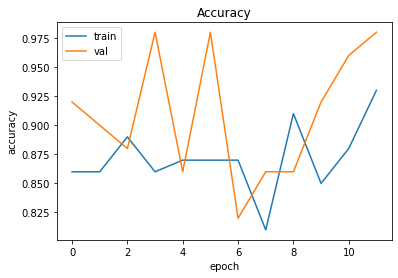

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

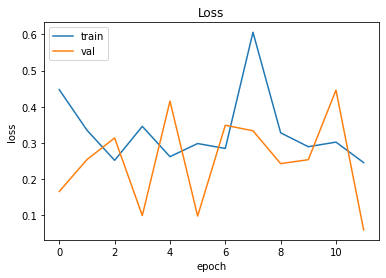

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Save Model to TF-Lite

In [62]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('shoe.tflite')
tflite_model_file.write_bytes(tflite_model)

13821368